In [0]:
import os, sys, numpy as np, pandas as pd, tensorflow as tf, re, codecs, json, time
import pickle, collections, random, math, numbers, scipy.sparse as sp, itertools, shutil

def reload(mName):
    import importlib
    if mName in sys.modules:
        del sys.modules[mName]
    return importlib.import_module(mName)

from collections import OrderedDict
from sklearn.preprocessing import minmax_scale
from scipy.sparse.linalg import svds
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
plt.style.use('ggplot')

utils = reload('utils.utils')
from utils.utils import *

np.set_printoptions(precision=4, suppress=True, linewidth=100)
randomSeed = 88
np.random.seed(randomSeed)

<br/>
<br/>
<br/>

# Data Prepare

In [0]:
ratings, movies, uidEnc, midEnc, nUsers, nMovies, midMap, tr, te, trRatingMat, teRatingMat = prepare()

In [3]:
ratings.head()

,userId,movieId,rating,timestamp
0,0,30,2.5,1260759144
1,0,833,3.0,1260759179
2,0,859,3.0,1260759182
3,0,906,2.0,1260759185
4,0,931,4.0,1260759205


In [4]:
# movies profile
movies.head()

,movieId,title,genres
0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,Jumanji (1995),Adventure|Children|Fantasy
2,2,Grumpier Old Men (1995),Comedy|Romance
3,3,Waiting to Exhale (1995),Comedy|Drama|Romance
4,4,Father of the Bride Part II (1995),Comedy


## 以leave one out方式產生 train data, test data
1. 每一筆資料有兩部分: [user query] + [item id]
2. 每一筆user query 包含所有user movie history, 除了當前的rating movie (candidate movie)
3. test data的user query來自於train data

In [5]:
def preprocess(data, train_hist=None, is_train=True):
    queue = []
    for u, df in data.groupby("userId"):
        df = df.sort_values("rating", ascending=False)
        if not is_train:
            user_movies_hist = train_hist.query("userId == {}".format(u)).movieId
        for i, (_, r) in enumerate(df.iterrows()):
            if is_train:
                queue.append([int(r.userId), df.movieId[:i].tolist() + df.movieId[i + 1:].tolist(), int(r.movieId), r.rating])
            else:
                # all_hist = set(user_movies_hist.tolist() + df.movieId[:i].tolist())
                all_hist = set(user_movies_hist.tolist())
                queue.append([int(r.userId), list(all_hist - set([int(r.movieId)])), int(r.movieId), r.rating])
    return pd.DataFrame(queue, columns=["user_id", "query_movie_ids", "candidate_movie_id", "rating"])

trProcessed = preprocess(tr)
teProcessed = preprocess(te, tr, is_train=False)
trProcessed.head()

,user_id,query_movie_ids,candidate_movie_id,rating
0,0,"[1515, 1083, 833, 859, 30, 1111, 906, 1017, 10...",931,4.0
1,0,"[931, 1083, 833, 859, 30, 1111, 906, 1017, 104...",1515,4.0
2,0,"[931, 1515, 833, 859, 30, 1111, 906, 1017, 104...",1083,3.5
3,0,"[931, 1515, 1083, 859, 30, 1111, 906, 1017, 10...",833,3.0
4,0,"[931, 1515, 1083, 833, 30, 1111, 906, 1017, 10...",859,3.0


In [6]:
teProcessed.head()

,user_id,query_movie_ids,candidate_movie_id,rating
0,0,"[833, 931, 1083, 906, 1515, 1041, 1140, 1111, ...",1665,4.0
1,0,"[833, 931, 1083, 906, 1515, 1041, 1140, 1111, ...",1708,3.0
2,0,"[833, 931, 1083, 906, 1515, 1041, 1140, 1111, ...",2925,3.0
3,0,"[833, 931, 1083, 906, 1515, 1041, 1140, 1111, ...",1962,2.5
4,0,"[833, 931, 1083, 906, 1515, 1041, 1140, 1111, ...",1743,2.0


## Data Function
1. 由於tensorflow placeholder不支援變動長度的columns, 需透過padding zero(補零)帶入
2. 每個變動長度的column, 需要再給lens描述每一筆資料的長度, ex: query_movie_ids, query_movie_ids_len

In [7]:
def dataFn(data, n_batch=128, shuffle=False):
    pad = tf.keras.preprocessing.sequence.pad_sequences
    def fn():
        dataInner = data.copy()
        indices = utils.get_minibatches_idx(len(dataInner), n_batch, shuffle=shuffle)
        for ind in indices:
            yield do_multi(dataInner.iloc[ind], ["query_movie_ids"])
    return fn

for i, e in enumerate(dataFn(trProcessed, n_batch=3, shuffle=True)(), 1):
    break
pd.DataFrame(e)

,user_id,query_movie_ids,query_movie_ids_len,candidate_movie_id,rating
0,47,"[263, 2860, 3856, 6034, 2409, 2374, 7128, 5339...",357,1393,4.5
1,175,"[966, 5026, 4395, 6042, 3871, 6521, 5020, 953,...",177,4002,3.0
2,261,"[45, 1104, 154, 4514, 4171, 3801, 3727, 3644, ...",471,3089,2.0


<br/>
<br/>
<br/>

# Tensorflow Model Based Matrix Factorization With History

In [0]:
class ModelMFWithHistory(object):
    def __init__(self, n_items, dim=32, learning_rate=0.01, reg=0.05, modelDir="./model/model_mf_with_history"):
        self.n_items = n_items
        self.dim = dim
        self.learning_rate = learning_rate
        self.reg = reg
        self.modelDir = modelDir
        graph = tf.Graph()
        with graph.as_default():
            # inputs parts
            graph_inputs(self)
            # embedding parts
            graph_embedding(self)
            # computation parts
            graph_computation(self)
            # loss parts
            graph_loss(self)
            self.saver = tf.train.Saver(tf.global_variables())
            self.graph = graph
        
    def fit(self, sess, trainGen, testGen, reset=False, nEpoch=50):
        return fit(self, sess, trainGen, testGen, reset=reset, nEpoch=nEpoch)
    
    def predict(self, sess, users: list):
        return predict(self, sess, users)
    
    def resetModel(self, modelDir):
        """刪除model dir"""
        shutil.rmtree(path=modelDir, ignore_errors=True)
        os.makedirs(modelDir)
        
    def ckpt(self, sess, modelDir):
        """load latest saved model"""
        latestCkpt = tf.train.latest_checkpoint(modelDir)
        if latestCkpt:
            self.saver.restore(sess, latestCkpt)
        return latestCkpt
    
    def feed_dict(self, data, mode="train"):
        """處理資料進placeholder的邏輯"""
        ret = {
            self.query_movie_ids: data["query_movie_ids"],
            self.query_movie_ids_len: data["query_movie_ids_len"],
            self.candidate_movie_id: data["candidate_movie_id"]
        }
        ret[self.isTrain] = False
        if mode != "infer":
            ret[self.rating] = data["rating"]
            if mode == "train":
                ret[self.isTrain] = True
            elif mode == "eval":
                pass
        return ret
    
    def epochLoss(self, sess, dataGen, tpe="rmse"):
        totLoss, totCnt = 0, 0
        # loss_map = {"rmse": self.rmse_loss, "mae": self.mae_loss, "target_loss": self.loss}
        for data in dataGen():
            lossTensor = self.rmse_loss if tpe == "rmse" else self.mae_loss
            loss = sess.run(lossTensor, feed_dict=self.feed_dict(data, mode="eval"))
            totLoss += (loss ** 2 if tpe == "rmse" else loss) * len(data["query_movie_ids"])
            totCnt += len(data["query_movie_ids"])
        return np.sqrt(totLoss / totCnt) if tpe == "rmse" else totLoss / totCnt
    
    def evaluateRMSE(self, sess, dataGen):
        """計算root mean square error"""
        self.ckpt(sess, self.modelDir)
        return self.epochLoss(sess, dataGen, tpe="rmse")

    def evaluateMAE(self, sess, dataGen):
        """計算 mean absolutely error"""
        self.ckpt(sess, self.modelDir)
        return self.epochLoss(sess, dataGen, tpe="mae")

## 設定Inputs placeholders

In [0]:
def graph_inputs(self):
    with tf.variable_scope("inputs"):
        self.isTrain = tf.placeholder(tf.bool, None)
        # user data
        self.query_movie_ids = tf.placeholder(tf.int32, [None, None])
        self.query_movie_ids_len = tf.placeholder(tf.int32, [None])
        # item data
        self.candidate_movie_id = tf.placeholder(tf.int32, [None])
        # labels
        self.rating = tf.placeholder(tf.float32, [None])

## Embedding部分 = One Hot Encoding + Linear Transformation<br/>
### tensorflow 提供 tf.nn.embedding_lookup function
1. user and item 都使用embedding
2. **user bias, item bias 個別使用query_emb, candidate_emb projection取得, projection方式即使用tensorflow tf.matmul運算即可**

In [0]:
def graph_embedding(self):
    init_fn = tf.glorot_normal_initializer()
    emb_init_fn = tf.glorot_uniform_initializer()
    self.b_global = tf.Variable(emb_init_fn(shape=[]), name="b_global")
    with tf.variable_scope("embedding"):
        # embedding dictionary
        self.w_query_movie_ids = tf.Variable(emb_init_fn(shape=[self.n_items, self.dim]), name="w_query_movie_ids")
        self.b_query_movie_ids = tf.Variable(emb_init_fn(shape=[self.dim]), name="b_query_movie_ids")
        self.w_candidate_movie_id = tf.Variable(init_fn(shape=[self.n_items, self.dim]), name="w_candidate_movie_id")
        self.b_candidate_movie_id = tf.Variable(init_fn(shape=[self.dim]), name="b_candidate_movie_id")

        self.query_emb = tf.nn.embedding_lookup(self.w_query_movie_ids, self.query_movie_ids)
        self.candidate_emb = tf.nn.embedding_lookup(self.w_candidate_movie_id, self.candidate_movie_id)
        self.candidate_bias = tf.matmul(self.candidate_emb, self.b_candidate_movie_id[:, tf.newaxis])

## Computation: 帶公式
$$ u_i \cdot m_j + b_u + b_m + b_{global} $$

1. Sqrtn pooling: X: data, W: weight <br/>
$ \frac{X_1W_1 + X_2W_2 + ... + X_nW_n} {\sqrt{W_1^2 + W_2^2 + ... W_n^2}} $ = X * normalize(W), 以這裡來說Weights全部都是1

2. self.infer與self.pred節點是帶同樣的公式, 但是self.pred節點快上許多


In [0]:
def graph_computation(self):
    with tf.variable_scope("computation"):
        '''sqrtn aggregation(pooling), X: data, W: weight
               X_1*W_1 + X_2*W_2 + ... + X_n*W_n / sqrt(W_1**2 + W_2**2 + ... W_n**2)
             = weighted sum of X and normalized W
           here data = self.query_emb, weight = weighted '''
        query_emb_mask = tf.sequence_mask(self.query_movie_ids_len)
        weighted = tf.nn.l2_normalize(tf.to_float(query_emb_mask), 1)[:, :, tf.newaxis]
        self.query_emb = tf.reduce_sum(self.query_emb * weighted, 1)
        self.query_bias = tf.matmul(self.query_emb, self.b_query_movie_ids[:, tf.newaxis])

        infer = tf.reduce_sum(self.query_emb * self.candidate_emb, 1, keep_dims=True)
        infer = tf.add(infer, self.b_global)
        infer = tf.add(infer, self.query_bias)
        self.infer = tf.add(infer, self.candidate_bias, name="infer")
        # one query for all items
        self.pred = tf.matmul(self.query_emb, tf.transpose(self.w_candidate_movie_id)) + \
                    tf.reshape(tf.matmul(self.w_candidate_movie_id, 
                                         self.b_candidate_movie_id[:, tf.newaxis]), (1, -1)) + \
                    self.query_bias + \
                    self.b_global

## Loss and Regularizer Term
1. 使用MSE優化整個model
2. RMSE and MAE loss節點並不在training graph中, 主要在eval的時候可以觀察變化
3. 使用 L2 regularization

In [0]:
def graph_loss(self):
    with tf.variable_scope("loss"): 
        self.regularizer = self.reg * (tf.nn.l2_loss(self.query_emb)     + tf.nn.l2_loss(self.query_bias) +
                                       tf.nn.l2_loss(self.candidate_emb) + tf.nn.l2_loss(self.candidate_bias))
        # l2_loss: Computes half the L2 norm of a tensor without the sqrt => sum(t ** 2) / 2
        # self.loss = tf.nn.l2_loss(self.infer - self.rating[:, tf.newaxis]) + self.regularizer
        self.loss = tf.losses.mean_squared_error(labels=self.rating[:, tf.newaxis], predictions=self.infer) + self.regularizer

        # for eval
        self.rmse_loss = tf.sqrt(tf.losses.mean_squared_error(labels=self.rating[:, tf.newaxis], predictions=self.infer))
        self.mae_loss = tf.reduce_mean(tf.abs(self.infer - self.rating[:, tf.newaxis]))
        pass
    
    with tf.variable_scope("train"):
        self.train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(self.loss)

## Fit: Training Function
1. reset: if True, clean the checkpoints save data
2. 計算epoch loss: 每個batch的loss * batch數量總和後除以epoch總數
3. training過程中會記錄valid loss, 只會儲存最低的loss => 另一種對付overfitting的方式

In [0]:
def fit(self, sess, trainGen, testGen, reset=False, nEpoch=50):
    """model training"""
    sess.run(tf.global_variables_initializer())
    if reset:
        print("reset model: clean model dir: {} ...".format(self.modelDir))
        self.resetModel(self.modelDir)
    self.ckpt(sess, self.modelDir)

    start = time.time()
    print("%s\t%s\t%s\t%s" % ("Epoch", "Train Error", "Val Error", "Elapsed Time"))
    minLoss = 1e7
    for ep in range(1, nEpoch + 1):
        tr_loss, tr_total = 0, 0
        for i, data in enumerate(trainGen(), 1):
            loss, _ = sess.run([self.rmse_loss, self.train_op], feed_dict=self.feed_dict(data, mode="train"))
            tr_loss += loss ** 2 * len(data["query_movie_ids"])
            tr_total += len(data["query_movie_ids"])
            print("\rtrain loss: {:.3f}".format(loss), end="")
        if testGen is not None:
            epochLoss = self.epochLoss(sess, testGen)

        tpl = "\r%02d\t%.3f\t\t%.3f\t\t%.3f secs"
        if minLoss > epochLoss:
            tpl += ", saving ..."
            self.saver.save(sess, os.path.join(self.modelDir, 'model'), global_step=ep)
            minLoss = epochLoss

        end = time.time()
        print(tpl % (ep, np.sqrt(tr_loss / tr_total), epochLoss, end - start))
        start = end
    return self

## Prediction: 每個User產出對所有Items的評分

In [0]:
def predict(self, sess, user_queries):
    self.ckpt(sess, self.modelDir)
    return sess.run(self.pred, feed_dict=self.feed_dict(user_queries, mode="infer"))

# Training

In [15]:
# !cp -a ./model/model_mf_with_history_bak/* ./model/model_mf_with_history/
# hyper parameters
n_batch = 128
learning_rate = 0.05
dim = 16
reg = 0.005
modelDir = "./model/model_mf_with_history"

tf.reset_default_graph()
model = ModelMFWithHistory(
            n_items=nMovies,
            dim=dim,
            reg=reg,
            learning_rate=learning_rate,
            modelDir=modelDir)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [16]:
with tf.Session(graph=model.graph) as sess:
    model.fit(sess, dataFn(trProcessed, n_batch=n_batch, shuffle=True), dataFn(teProcessed, n_batch=n_batch), nEpoch=10, reset=True)

reset model: clean model dir: ./model/model_mf_with_history ...
Epoch	Train Error	Val Error	Elapsed Time
01	1.088		0.986		17.521 secs, saving ...
02	0.980		0.965		17.099 secs, saving ...
03	0.949		0.952		17.055 secs, saving ...
04	0.927		0.944		16.967 secs, saving ...
05	0.910		0.945		17.053 secs
06	0.898		0.938		17.112 secs, saving ...
07	0.889		0.931		17.097 secs, saving ...
08	0.882		0.927		17.215 secs, saving ...
09	0.877		0.926		17.086 secs, saving ...
10	0.872		0.925		17.113 secs, saving ...


## Another Data Function For Predict: user_data
1. user_data function: 單純改變function參數, 可指定user id

In [17]:
for u_data in user_data(trProcessed, [0, 1], n_batch=5):
    break
pd.DataFrame(u_data)

/content/utils/utils.py:297: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  u_rec.set_value("query_movie_ids", u_rec.query_movie_ids + [u_rec.candidate_movie_id])


,user_id,query_movie_ids,query_movie_ids_len,candidate_movie_id
0,0,"[1515, 1083, 833, 859, 30, 1111, 906, 1017, 10...",13,931
1,1,"[16, 129, 195, 237, 238, 9, 280, 454, 447, 427...",52,37


## 單一user rating分布圖

INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history/model-10
shape:  (1, 9125) [[0.7806 0.63   0.5109 ... 0.628  0.654  0.6577]]


/content/utils/utils.py:297: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  u_rec.set_value("query_movie_ids", u_rec.query_movie_ids + [u_rec.candidate_movie_id])


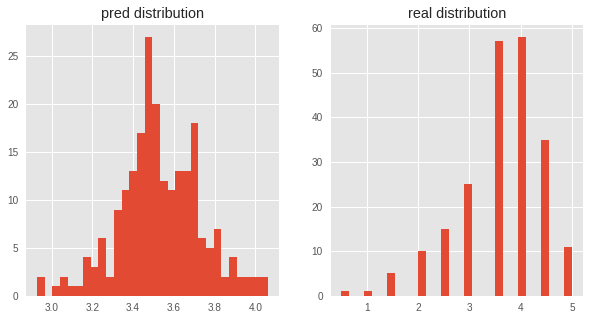

In [18]:
from sklearn.preprocessing import minmax_scale
# user id from 0 ~ 670
uid = 22
u_data = list(user_data(trProcessed, [uid], n_batch=5))[0]
with tf.Session(graph=model.graph) as sess:
    pred = model.predict(sess, u_data)
print("shape: ", pred.shape, minmax_scale(pred.T).T)

nnzCoord = teRatingMat[uid].nonzero()
f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title("pred distribution")
pd.Series(pred.ravel()[nnzCoord]).hist(bins=30, ax=ax[0])
ax[1].set_title("real distribution")
pd.Series(map(lambda e: e, teRatingMat[uid][nnzCoord])).hist(bins=30, ax=ax[1])
plt.show()

<br/>
<br/>
<br/>

# Evaluate model

In [19]:
%%time
n_batch=128
with tf.Session(graph=model.graph) as sess:
    mae_ = model.evaluateMAE(sess, dataFn(teProcessed, n_batch=n_batch))
    rmse_ = model.evaluateRMSE(sess, dataFn(teProcessed, n_batch=n_batch))

print()
print("MAE loss: ", mae_)
print("RMSE loss: ", rmse_)

INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history/model-10
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history/model-10

MAE loss:  0.723452079588244
RMSE loss:  0.9248596236269511
CPU times: user 6.37 s, sys: 165 ms, total: 6.53 s
Wall time: 4.79 s


## User導向評估(Recall)

In [20]:
# 可給定user id細看每個user的rating與model預測效果
# valid user id from 0 ~ 670
uid = 22
with tf.Session(graph=model.graph) as sess:
    u_data = list(user_data(trProcessed, [uid], n_batch=5))[0]
    recomm = model.predict(sess, u_data).ravel()
recommDf = pd.DataFrame(data={
              "userId": uid,
              "movieId": range(len(recomm)), 
              "title": midMap[np.arange(len(recomm))].values, 
              "rating": teRatingMat[uid, range(len(recomm))],
              "predRating": recomm},
             columns=("userId", "movieId", "title", "rating", "predRating"))
# ascending 可以調整True or False觀察結果
recommDf.query("rating != 0").sort_values("rating", ascending=False).head(50)

INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history/model-10


/content/utils/utils.py:297: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  u_rec.set_value("query_movie_ids", u_rec.query_movie_ids + [u_rec.candidate_movie_id])


,userId,movieId,title,rating,predRating
4417,22,4417,Catch Me If You Can (2002),5.0,3.811416
5623,22,5623,Undertow (2004),5.0,3.472254
4419,22,4419,"Hours, The (2002)",5.0,3.578226
4432,22,4432,City of God (Cidade de Deus) (2002),5.0,4.053556
4371,22,4371,Adaptation (2002),5.0,3.881796
4008,22,4008,And Your Mother Too (Y tu mamá también) (2001),5.0,3.683190
6132,22,6132,Crash (2004),5.0,3.707162
5016,22,5016,Stolen Kisses (Baisers volés) (1968),5.0,3.555396
5761,22,5761,Duel (1971),5.0,3.477825
4875,22,4875,"Unvanquished, The (Aparajito) (1957)",5.0,3.549934


## Model導向評估(Precision)

In [21]:
# .query("rating != 0")
recommDf.query("rating != 0").sort_values("predRating", ascending=False).head(50)

,userId,movieId,title,rating,predRating
5127,22,5127,Eternal Sunshine of the Spotless Mind (2004),4.5,4.060305
4432,22,4432,City of God (Cidade de Deus) (2002),5.0,4.053556
6042,22,6042,Howl's Moving Castle (Hauru no ugoku shiro) (2...,3.5,4.012623
4411,22,4411,My Neighbor Totoro (Tonari no Totoro) (1988),4.5,4.002925
4422,22,4422,"Pianist, The (2002)",4.5,3.981042
4231,22,4231,Spirited Away (Sen to Chihiro no kamikakushi) ...,3.5,3.966745
6383,22,6383,V for Vendetta (2006),4.5,3.939456
5026,22,5026,"Lord of the Rings: The Return of the King, The...",4.5,3.911825
4991,22,4991,Hero (Ying xiong) (2002),4.5,3.895428
4048,22,4048,Rashomon (Rashômon) (1950),4.0,3.886912


INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history/model-10


/content/utils/utils.py:297: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  u_rec.set_value("query_movie_ids", u_rec.query_movie_ids + [u_rec.candidate_movie_id])


INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history/model-10
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history/model-10
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history/model-10
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history/model-10
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history/model-10
auc: 0.7462788495919063


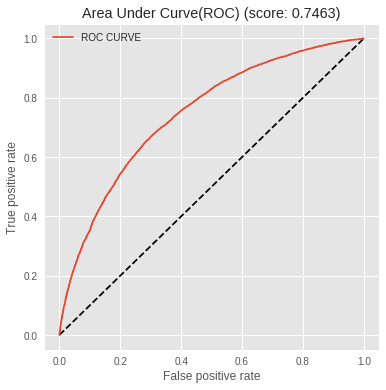

In [22]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
    
coord = teRatingMat.nonzero()
with tf.Session(graph=model.graph) as sess:
    predMat = []
    for u_data in user_data(teProcessed, np.arange(nUsers), n_batch=128):
        predMat.append(model.predict(sess, u_data))
    predMat = np.vstack(predMat)
# regard rating >= 4 as user like this movie
drawRocCurve((teRatingMat[coord] >= 4).astype(int), predMat[coord])

## Precision at K (K=10)

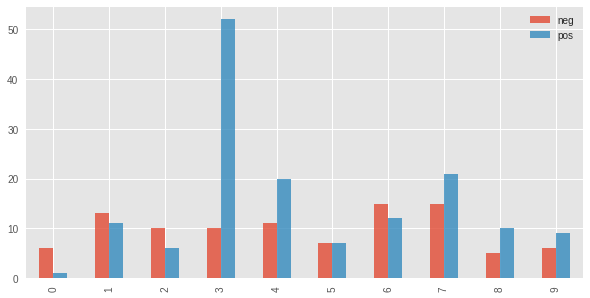

In [23]:
pos_ary, neg_ary = [], []
for label in teRatingMat:
    label = label[label != 0]
    pos_ary.append(sum(label >= 4))
    neg_ary.append(sum(label < 4))
    # print("pos: {}, neg: {}".format(sum(label >= 4), sum(label < 4)))
    
def draw_pos_neg(idx):
    pd.DataFrame(
        index=idx,
        data={"pos": np.array(pos_ary)[idx], "neg": np.array(neg_ary)[idx]}).plot.bar(figsize=(10, 5), alpha=0.8)
    plt.show()

draw_pos_neg(np.arange(len(teRatingMat))[0:10])

## About Test Data Movie Ratings(觀察上圖)
1. 0號, 2號, 5號, 9號 user 正向評價數量 < 10, 就算model全部預測命中, 命中率也不會是 100%!
    ex: 0號user只有1個正向評價, 全部命中也指得到0.1的分數
2. 3號user正向評價是負向評價的5倍多, 就算亂猜, 中的機率也很高

In [24]:
_ = sum(np.sum(teRatingMat >= 4, 1) < 10)
print("{} 個user正向評價總數小於10!".format(_))

266 個user正向評價總數小於10!


In [25]:
print("rating數量 >= 10 且 負評價數量 >= 正評價數量 有 [{}] 人".format(sum(strict_condition(label) for label in teRatingMat)))
print("rating正評價數量 >= 0 且 rating負評價數量 >= 0 有 [{}] 人".format(sum(norm_condition(label) for label in teRatingMat)))

rating數量 >= 10 且 負評價數量 >= 正評價數量 有 [209] 人
rating正評價數量 >= 0 且 rating負評價數量 >= 0 有 [669] 人


### Precision At K: 
> **預測分數高(rating >= 4)的前10部電影, 和實際user rating比較, 觀察命中率**

In [26]:
%%time
from sklearn.metrics import precision_score

with tf.Session(graph=model.graph) as sess:
    pred_mat= []
    for u_data in user_data(trProcessed, np.arange(nUsers), n_batch=n_batch):
        pred_mat.append(model.predict(sess, u_data))
    pred_mat = np.vstack(pred_mat)
    
print( "strict condition precision at 10: ", precision_at_k(teRatingMat, pred_mat, strict_condition, k=10) )
print( "norm condition precision at 10: ", precision_at_k(teRatingMat, pred_mat, norm_condition, k=10) )

INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history/model-10


/content/utils/utils.py:297: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  u_rec.set_value("query_movie_ids", u_rec.query_movie_ids + [u_rec.candidate_movie_id])


INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history/model-10
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history/model-10
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history/model-10
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history/model-10
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history/model-10
strict condition precision at 10:  0.5095693779904307
norm condition precision at 10:  0.633034379671151
CPU times: user 1.44 s, sys: 43.5 ms, total: 1.48 s
Wall time: 1.46 s


## NDCG: Normalized Discounted Cumulative Gain
1. A measure of ranking quality.
2. loop 每一位user, prediciton score排序後計算NDCG
    <br/>$$ DCG_p = \sum^p_{i = 1} \frac{2^{rel_i} - 1}{log_2(i + 1)} $$<br/>
3. IDCG: Ideal DCG, 為理想狀態下的DCG分數, 即model全部命中的DCG分數, 而NDCG: Normalized DCG, 公式如下
    <br/>$$ NDCG_p = \sum^p_{i = 1} \frac{DCG_p}{IDCG_p} $$<br/>
4. 所以NDCG是一個比值, 介於0 ~ 1之間

In [27]:
with tf.Session(graph=model.graph) as sess:
    pred_mat= []
    for u_data in user_data(trProcessed, np.arange(nUsers), n_batch=n_batch):
        pred_mat.append(model.predict(sess, u_data))
    pred_mat = np.vstack(pred_mat)
    
strict_ndcg = all_user_ndcg(teRatingMat, pred_mat, strict_condition, label_thres=4, k=10)
norm_ndcg = all_user_ndcg(teRatingMat, pred_mat, norm_condition, label_thres=4, k=10)
print("strict condition ndcg at 10: ", strict_ndcg)
print("norm condition ndcg at 10: ", norm_ndcg)

INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history/model-10


/content/utils/utils.py:297: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  u_rec.set_value("query_movie_ids", u_rec.query_movie_ids + [u_rec.candidate_movie_id])


INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history/model-10
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history/model-10
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history/model-10
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history/model-10
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history/model-10
strict condition ndcg at 10:  0.6297434643263478
norm condition ndcg at 10:  0.7593757776459449


<br/>
<br/>
<br/>

# 取出movies embedding, 使用cosine similarity列出最相似的電影

In [28]:
movies[movies.title.str.contains("Toy")]

,movieId,title,genres
0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1579,1579,Babes in Toyland (1961),Children|Fantasy|Musical
1780,1780,Toys (1992),Comedy|Fantasy
2479,2479,Babes in Toyland (1934),Children|Comedy|Fantasy|Musical
2506,2506,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
3829,3829,"Toy, The (1982)",Comedy
4341,4341,Toy Soldiers (1991),Action|Drama
7556,7556,Toy Story 3 (2010),Adventure|Animation|Children|Comedy|Fantasy|IMAX
8437,8437,Toy Story of Terror (2013),Animation|Children|Comedy


In [29]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

def most_like(model, seed_movie, k=10):
    """給定某一部電影, 使用model裡movies embedding找尋cosine相似度高的其他電影!"""
    with tf.Session(graph=model.graph) as sess:
        model.ckpt(sess, model.modelDir)
        movie_emb = sess.run(model.candidate_emb, feed_dict={model.candidate_movie_id: movies.movieId.values})
        
    most_like = cosine_similarity(movie_emb[seed_movie][np.newaxis, :], movie_emb).ravel().argsort()[::-1][:k]
    return movies.iloc[most_like]

most_like(model, 0, k=10)

INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history/model-10


,movieId,title,genres
0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
748,748,Rebecca (1940),Drama|Mystery|Romance|Thriller
2956,2956,Mad Max (1979),Action|Adventure|Sci-Fi
1008,1008,"Treasure of the Sierra Madre, The (1948)",Action|Adventure|Drama|Western
741,741,Gone with the Wind (1939),Drama|Romance|War
2688,2688,Dog Day Afternoon (1975),Crime|Drama
931,931,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama
522,522,Terminator 2: Judgment Day (1991),Action|Sci-Fi
284,284,"Shawshank Redemption, The (1994)",Crime|Drama
232,232,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
